In [96]:
import pandas as pd 
import numpy as np 
import datetime 
from matplotlib import pyplot as plt

from CV import cross_validation as CV
from CV import combinatorial as CB
from CPCV_util import TrainValidPathNum


# Order 
1. X, Y generation 
2. CPCV baseline 
   어차피 여기서 뒤에서 개수만큼 잘라주는 거면 데이터 포인트를 자르는 것과 다를바 없음
3. Path return function
   


In [97]:
import pandas as pd
import numpy as np 

In [98]:
df = pd.read_csv("./data/data_input_demo.csv", index_col = [0])
df = df.set_index(['date'])[['13ty_index', 'interty_index', 'lty_index', 'mbs_index',\
       '13cy_index', 'intercy_index', 'lcy_index', 'ty_index', 'cy_index','agg_index']]
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')

In [99]:
df.head()

,13ty_index,interty_index,lty_index,mbs_index,13cy_index,intercy_index,lcy_index,ty_index,cy_index,agg_index
date,,,,,,,,,,
1997-05-19,133.46,784.22,840.64,751.37,668.10,893.58,912.47,824.23,861.00,715.66
1997-05-20,133.58,785.01,840.34,751.82,668.74,894.56,912.29,824.78,861.51,716.09
1997-05-21,133.59,784.63,836.47,751.97,668.77,893.58,908.76,823.54,859.71,715.31
1997-05-22,133.58,784.33,834.66,751.97,668.71,892.96,906.86,822.86,858.69,714.88
1997-05-23,133.58,784.70,835.59,752.27,668.71,893.58,907.77,823.37,859.37,715.31


## X, Y generation 

In [100]:

def generate_xy_seq(df: pd.DataFrame, x_seq = 66, y_seq = 22):
    """
    Generate samples from
    :param df:
    :param x_seq:
    :param y_seq:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """
    num_samples, num_nodes = df.shape
    dates_arr = np.array(df.index)
    data = np.expand_dims(df.values, axis = -1) # df -> array [N, F, 1]

    x_offsets = np.arange(-x_seq+1, 1)  
    y_offsets = np.arange(1, y_seq+1)

    # feature_list = [data]

    x, y = [], []
    x_date, y_date = [],[]

    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))

    for t in range(min_t, max_t):
        # value seperation
        x.append(data[t+x_offsets, ...])
        y.append(data[t+y_offsets, ...])
        # date seperation
        x_date.append(dates_arr[t+x_offsets])
        y_date.append(dates_arr[t+y_offsets])
        
    x = np.squeeze(np.stack(x, axis = 0))
    y = np.squeeze(np.stack(y, axis = 0))

    x_date = np.stack(x_date, axis = 0)
    y_date = np.stack(y_date, axis = 0)

    return x, y, x_date, y_date

In [101]:
past_seq = 66
future_seq = 22
num_assets = df.shape[1]
X, Y, X_date, Y_date = generate_xy_seq(df, x_seq = past_seq, y_seq = future_seq)

In [102]:
X.shape

(6298, 66, 10)

In [103]:
Y.shape

(6298, 22, 10)

In [104]:
X.shape

(6298, 66, 10)

In [105]:
X_date

array([['1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', ...,
        '1997-08-14T00:00:00.000000000', '1997-08-15T00:00:00.000000000',
        '1997-08-18T00:00:00.000000000'],
       ['1997-05-20T00:00:00.000000000', '1997-05-21T00:00:00.000000000',
        '1997-05-22T00:00:00.000000000', ...,
        '1997-08-15T00:00:00.000000000', '1997-08-18T00:00:00.000000000',
        '1997-08-19T00:00:00.000000000'],
       ['1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', ...,
        '1997-08-18T00:00:00.000000000', '1997-08-19T00:00:00.000000000',
        '1997-08-20T00:00:00.000000000'],
       ...,
       ['2021-07-05T00:00:00.000000000', '2021-07-06T00:00:00.000000000',
        '2021-07-07T00:00:00.000000000', ...,
        '2021-09-30T00:00:00.000000000', '2021-10-01T00:00:00.000000000',
        '2021-10-04T00:00:00.000000000'],
       ['2021-07-06T00:00:00.000000000', '20

In [106]:
Y_date

array([['1997-08-19T00:00:00.000000000', '1997-08-20T00:00:00.000000000',
        '1997-08-21T00:00:00.000000000', ...,
        '1997-09-15T00:00:00.000000000', '1997-09-16T00:00:00.000000000',
        '1997-09-17T00:00:00.000000000'],
       ['1997-08-20T00:00:00.000000000', '1997-08-21T00:00:00.000000000',
        '1997-08-22T00:00:00.000000000', ...,
        '1997-09-16T00:00:00.000000000', '1997-09-17T00:00:00.000000000',
        '1997-09-18T00:00:00.000000000'],
       ['1997-08-21T00:00:00.000000000', '1997-08-22T00:00:00.000000000',
        '1997-08-25T00:00:00.000000000', ...,
        '1997-09-17T00:00:00.000000000', '1997-09-18T00:00:00.000000000',
        '1997-09-19T00:00:00.000000000'],
       ...,
       ['2021-10-05T00:00:00.000000000', '2021-10-06T00:00:00.000000000',
        '2021-10-07T00:00:00.000000000', ...,
        '2021-11-01T00:00:00.000000000', '2021-11-02T00:00:00.000000000',
        '2021-11-03T00:00:00.000000000'],
       ['2021-10-06T00:00:00.000000000', '20

In [107]:
sample_info_sets = pd.Series(index=df[:-(past_seq+future_seq-1)].index, data=df[(past_seq+future_seq-1):].index)

In [108]:
sample_info_sets

date
1997-05-19   1997-09-17
1997-05-20   1997-09-18
1997-05-21   1997-09-19
1997-05-22   1997-09-22
1997-05-23   1997-09-23
                ...    
2021-07-01   2021-11-01
2021-07-02   2021-11-02
2021-07-05   2021-11-03
2021-07-06   2021-11-04
2021-07-07   2021-11-05
Name: date, Length: 6298, dtype: datetime64[ns]

In [109]:
"""
Implements the Combinatorial Purged Cross-Validation class from Chapter 12
"""
import sys 

from itertools import combinations
from typing import List

import pandas as pd
import numpy as np

from scipy.special import comb
from sklearn.model_selection import KFold
from CV.cross_validation import ml_get_train_times

def _get_number_of_backtest_paths(n_train_splits: int, n_test_splits: int) -> float:
    """
    Number of combinatorial paths for CPCV(N,K)
    :param n_train_splits: (int) number of train splits
    :param n_test_splits: (int) number of test splits
    :return: (int) number of backtest paths for CPCV(N,k)
    """
    return int(comb(n_train_splits, n_train_splits - n_test_splits) * n_test_splits / n_train_splits)


class CombinatorialPurgedKFold(KFold):
    """
    Advances in Financial Machine Learning, Chapter 12.

    Implements Combinatial Purged Cross Validation (CPCV)

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series, date value) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 n_test_splits: int = 2,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.,
                 purge_behind: bool = False):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(CombinatorialPurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo
        self.n_test_splits = n_test_splits
        self.num_backtest_paths = _get_number_of_backtest_paths(self.n_splits, self.n_test_splits) # self. 정의가 안 되어 있는데/./? 
        self.backtest_paths = []  # Array of backtest paths
        self.valid_comb = list(combinations([x for x in range(self.n_splits)], self.n_test_splits))
        self._set_path_indexs() # train 별 path index mapping 
        self.purge_behind = purge_behind
        
    def _set_path_indexs(self):
        train_path_count = [0 for _ in range(self.n_splits)]
        self.val_path_pair = {}
        for val_group in self.valid_comb: 
            path_comb = []
            for split_ind in val_group:
                path_comb.append(train_path_count[split_ind])
                train_path_count[split_ind] += 1
            self.val_path_pair[val_group] = tuple(path_comb)
        

    def _generate_combinatorial_test_ranges(self, splits_indices: dict) -> List:
        """
        Using start and end indices of test splits from KFolds and number of test_splits (self.n_test_splits),
        generates combinatorial test ranges splits

        :param splits_indices: (dict) Test fold integer index: [start test index, end test index]
        :return: (list) Combinatorial test splits ([start index, end index])
        """

        # Possible test splits for each fold
        combinatorial_splits = list(combinations(list(splits_indices.keys()), self.n_test_splits))
        combinatorial_test_ranges = []  # List of test indices formed from combinatorial splits
        for combination in combinatorial_splits:
            temp_test_indices = []  # Array of test indices for current split combination
            for int_index in combination:
                temp_test_indices.append(splits_indices[int_index])
            combinatorial_test_ranges.append(temp_test_indices)
        return combinatorial_test_ranges

    def _fill_backtest_paths(self, train_indices: list, test_splits: list):
        """
        Using start and end indices of test splits and purged/embargoed train indices from CPCV, find backtest path and
        place in the path where these indices should be used.

        :param test_splits: (list) of lists with first element corresponding to test start index and second - test end
        """
        # Fill backtest paths using train/test splits from CPCV
        for split in test_splits:
            found = False  # Flag indicating that split was found and filled in one of backtest paths
            for path in self.backtest_paths:
                for path_el in path:
                    if path_el['train'] is None and split == path_el['test'] and found is False:
                        path_el['train'] = np.array(train_indices)
                        path_el['test'] = list(range(split[0], split[-1]))
                        found = True

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
            # test_ranges : (st, end ind) for each split in the fold (e.g, fold set)
               
        
        splits_indices = {}
        for index, [start_ix, end_ix] in enumerate(test_ranges):
            splits_indices[index] = [start_ix, end_ix]

        combinatorial_test_ranges = self._generate_combinatorial_test_ranges(splits_indices)
        
        valid_order_comb_map = {} # 0: (0,1), 
        for i in range(len(self.valid_comb)):
            valid_order_comb_map[i] = self.valid_comb[i]
        
        spilt_ind_map = {}
        for i in range(len(self.valid_comb)): 
            spilt_ind_map[i] = self.valid_comb[i] 
        
        # Prepare backtest paths
        for _ in range(self.num_backtest_paths):
            path = []
            for split_idx in splits_indices.values():
                path.append({'train': None, 'test': split_idx})
            self.backtest_paths.append(path)

        embargo: int = int(X.shape[0] * self.pct_embargo)
        self.embargo = embargo
        
        for comb_order, test_splits in enumerate(combinatorial_test_ranges):
                # test_splits : [[0,10], [10, 21], [21, 31]]  test set 만 가지고 있음 
            
            if self.purge_behind:
                cv_set = {}
                val_comb_ind_set = valid_order_comb_map[comb_order]
                valid_set = {}
                train_set = {}
                
                for split_ind, _ in enumerate(test_ranges):
                    if split_ind in val_comb_ind_set: # validation
                        split = test_ranges[split_ind]
                        for st_ind, end_ind in [split]:
                            valid_ind = np.arange(st_ind,end_ind)
                            valid_set[split_ind] = (valid_ind)
                    else: # train
                        split = test_ranges[split_ind]
                        for st_ind, end_ind in [split]:
                            train_ind = np.arange(st_ind, end_ind)
                            train_set[split_ind] = (train_ind)
                cv_set['val'] = valid_set
                cv_set['train'] = train_set    
                
                # Purging & Embargo 
                train_indices, test_indices = self.purging(cv_set)
            else:
                # Embargo
                test_times = pd.Series(index=[self.samples_info_sets[ix[0]] for ix in test_splits], data=[
                    self.samples_info_sets[ix[1] - 1] if ix[1] - 1 + embargo >= X.shape[0] else self.samples_info_sets[
                        ix[1] - 1 + embargo]
                    for ix in test_splits])

                test_indices = []
                for [start_ix, end_ix] in test_splits:
                    test_indices.append(list(range(start_ix, end_ix)))

                # Purge
                train_times = ml_get_train_times(self.samples_info_sets, test_times)

                # Get indices
                train_indices = []
                for train_ix in train_times.index:
                    train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            
            valid_group_indices = spilt_ind_map[comb_order]
            path_ls = self.val_path_pair[valid_group_indices] # path_ls : [path num1, path num2,..path numN]

            self._fill_backtest_paths(train_indices, test_splits)

            yield path_ls, np.array(train_indices), [np.array(x) for x in test_indices]

    def purging(self, cv_set):
        """_summary_

        Args:
            cv_set (double nested dictionary)
                - keys : ['train', 'val']
                - value : 2nd dict
                    - keys: fold num [0, 1]
                    - values (np) 
        Return: 
            purged train or validation data set
        """
        purging_num = self.embargo
        embargo_num = self.embargo

        val_keys = list(cv_set['val'].keys())
        train_keys = list(cv_set['train'].keys())
        # print ("val_keys ", val_keys)
 
        for val_k in val_keys:
            # print (val_k)
            if val_k-1 in train_keys: # train | val -> val 앞 버리기 
                # print (" o | x ")
                cv_set['val'][val_k] = cv_set['val'][val_k][purging_num: ]
                if val_k+1 in train_keys: # val | train -> train 앞 버리기 
                    # print (" x | o ")
                    cv_set['train'][val_k+1] = cv_set['train'][val_k+1][embargo_num: ]

            elif val_k+1 in train_keys: # val | train -> train 앞 버리기 
                # print (" x | o ")
                cv_set['train'][val_k+1] = cv_set['train'][val_k+1][embargo_num: ]
                if val_k-1 in train_keys: # train | val -> val 앞 버리기 
                    # print (" o | x | ")
                    cv_set['val'][val_k] = cv_set['val'][val_k][purging_num: ]
        
        train_indices = [x for y in list(cv_set['train'].values()) for x in y]
        test_indices = cv_set['val'].values()

        return train_indices, test_indices

In [110]:
total_split_num = 6
val_split_num = 2
pct_embargo = 0.01

folds = [i for i in range(total_split_num)]
val_comb = list(combinations(folds, val_split_num))
train_split_num = total_split_num - val_split_num
path_fold_num  = train_split_num + 1 # 한 path 에 존재하는 fold 의 개수 / train_split_num + 1  = 5
path_num = int(len(val_comb) * val_split_num / total_split_num) # 전체 path 의 개수 = path_fold_num 

cv_gen = CombinatorialPurgedKFold(n_splits=total_split_num,
                         n_test_splits = val_split_num, 
                         samples_info_sets=sample_info_sets, 
                         pct_embargo=pct_embargo)

cv_split = cv_gen.split(X,Y)

In [111]:
df

,13ty_index,interty_index,lty_index,mbs_index,13cy_index,intercy_index,lcy_index,ty_index,cy_index,agg_index
date,,,,,,,,,,
1997-05-19,133.46,784.22,840.64,751.37,668.10,893.58,912.47,824.23,861.00,715.66
1997-05-20,133.58,785.01,840.34,751.82,668.74,894.56,912.29,824.78,861.51,716.09
1997-05-21,133.59,784.63,836.47,751.97,668.77,893.58,908.76,823.54,859.71,715.31
1997-05-22,133.58,784.33,834.66,751.97,668.71,892.96,906.86,822.86,858.69,714.88
1997-05-23,133.58,784.70,835.59,752.27,668.71,893.58,907.77,823.37,859.37,715.31
...,...,...,...,...,...,...,...,...,...,...
2021-11-01,277.95,2050.97,4522.48,2303.94,1728.81,3090.09,5252.00,2491.10,3441.88,2351.92
2021-11-02,278.22,2054.41,4540.20,2304.88,1730.46,3095.17,5270.93,2496.45,3450.09,2355.94
2021-11-03,278.18,2052.47,4498.21,2303.43,1730.23,3092.39,5245.17,2489.74,3441.78,2351.25


# CPCV with Training Process

In [112]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import torch 
from torch import nn 


# Base Model 

In [113]:
class LSTM_Model(nn.Module):
    def __init__(self, num_assets, past_seq, future_seq, num_layers, device):
        '''
        '''
        super(LSTM_Model, self).__init__()
        self.device = device
        self.num_layers = num_layers
        
        self.lstm_in_dim = num_assets
        self.lstm_out_dim = num_assets 
        
        self.fc_in_dim = past_seq
        self.fc_out_dim = future_seq

## LSTM 정의 
        self.lstm = nn.LSTM(self.lstm_in_dim, self.lstm_out_dim, num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Conv2d(self.fc_in_dim, self.fc_out_dim, kernel_size= (1,1))        
        
    def forward(self, x):
        '''
        x: [batch size, past sequence]
        '''
        batch_size = x.size(0)
## 초기 hidden state, cell state 정의해주기 : 0으로 준다
        hidden_init = torch.zeros(self.num_layers, batch_size, self.lstm_out_dim).to(self.device)
        cell_init = torch.zeros(self.num_layers, batch_size, self.lstm_out_dim).to(self.device)
        
        output, hidden = self.lstm(x, (hidden_init, cell_init))
        prediction = output.unsqueeze(-1)
        
####### 예측길이 바꿔주고 싶을 때 실행        
        prediction = self.fc(prediction)
        prediction = prediction.squeeze()
        
        return prediction         
        

In [114]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print ("Use gpu")
else:
    device = torch.device("cpu")
    print ("Use cpu")

Use gpu


In [115]:
# Model related hyper-parameters 
num_assets = df.shape[-1]
num_layers = 1 # 4 개의 RNN layer 을 쌓겠습니다. 
num_epochs = 100 # Epoch 횟수를 설정합니다. 

######### Model 을 정의하는 부분 ########
print ("** Model Loading **")
Model = LSTM_Model(num_assets, past_seq, future_seq, num_layers, device)

Model.to(device)

criterion = nn.L1Loss() # Loss function 을 정의합니다 : MAE
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01) # optimizer 을 설정해 줍니다. 

** Model Loading **


In [116]:
# Training related hyper-parameters
batch_num = 32
epoch_num = 30

In [117]:
total_split_num = 6
val_split_num = 2
pct_embargo = 0.01
purge_behind = True


folds = [i for i in range(total_split_num)]
val_comb = list(combinations(folds, val_split_num))
train_split_num = total_split_num - val_split_num
path_fold_num  = train_split_num + 1 # 한 path 에 존재하는 fold 의 개수 / train_split_num + 1  = 5
path_num = int(len(val_comb) * val_split_num / total_split_num) # 전체 path 의 개수 = path_fold_num 

cv_gen = CombinatorialPurgedKFold(n_splits=total_split_num,
                         n_test_splits = val_split_num, 
                         samples_info_sets=sample_info_sets, 
                         pct_embargo=pct_embargo,
                         purge_behind= purge_behind)

cv_split = cv_gen.split(X,Y)

In [118]:
import util

In [119]:
# Dataloader 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import numpy as np 

## Mostly adapted from original TFT Github, data_formatters
class DataIterator(Dataset):
    def __init__(self, data_iter):
        '''
        data_iter : data iterator that holds (x,y) 
        '''
        self.inputs =  data_iter['inputs']
        self.outputs = data_iter['outputs']       
        try:
            self.inputs_date = data_iter['inputs_date']
            self.outputs_date = data_iter['outputs_date']
        except:
            pass
    # Dataloader 에 들어갈 때, datetime 은 넣을수가 없다. -> float 으로 바꿔줘 
    
    def __getitem__(self, index):
        
        try:
            s = {
            'inputs': self.inputs[index],
            'outputs': self.outputs[index],
            'inputs_date': self.inputs_date[index],
            'outputs_date': self.outputs_date[index]
            }
        except:
            s = {
            'inputs': self.inputs[index],
            'outputs': self.outputs[index],
            }
            
        return s
    
    def __len__(self):
        return self.inputs.shape[0]
        
def CustomDataLoader(X, Y, X_date, Y_date, batch_size, device, shuffle = False):
    '''
    num_workers : number of multiprocessing for CPU
    '''    
    data_iter = {}
    data_iter['inputs'] = torch.from_numpy(X).float().to(device)
    data_iter['outputs'] = torch.from_numpy(Y).float().to(device)
    data_iter['inputs_date'] = X_date
    data_iter['outputs_date'] = Y_date
    
    data_iter_out = DataIterator(data_iter)
    dataloader = DataLoader(data_iter_out, batch_size = batch_size, shuffle = shuffle, drop_last=True) 
    return dataloader



In [128]:
data_iter = {}
data_iter['inputs'] = (X)
data_iter['outputs'] = Y
data_iter['inputs_date'] = np.array(X_date, 'float')
data_iter['outputs_date'] = np.array(Y_date, 'float')

# date 를 DataLoader 에 집어 넣어줄 때, 
    # float 로 만들어주기 -> 문제: 나중에 다시 datetime 으로 변환 (2중작업)
        # float 로 만들어주지 않으면 datetime 형식으로 들어가는데, 이는 DataLoader 에서 맞지 않는다
        
data_iter_out = DataIterator(data_iter)
dataloader = DataLoader(data_iter_out, batch_size = 32, shuffle = True, drop_last=True) 


In [130]:
next(iter(dataloader))

{'inputs': tensor([[[ 278.9200, 2077.2100, 4626.6000,  ..., 2527.9800, 3443.2600,
           2370.7500],
          [ 278.9500, 2079.0300, 4644.2800,  ..., 2531.7300, 3448.3800,
           2373.8800],
          [ 278.9500, 2079.0300, 4644.2800,  ..., 2531.7300, 3448.3800,
           2373.8800],
          ...,
          [ 278.9300, 2056.6900, 4260.0500,  ..., 2466.8200, 3364.7800,
           2327.9300],
          [ 278.9300, 2055.8300, 4247.7000,  ..., 2464.6000, 3363.8300,
           2326.8200],
          [ 278.9700, 2059.8900, 4312.9100,  ..., 2475.8700, 3382.2000,
           2335.7800]],
 
         [[ 263.6800, 1899.0400, 3639.8400,  ..., 2248.8700, 2937.9800,
           2098.9100],
          [ 263.8900, 1902.4100, 3666.0400,  ..., 2254.9500, 2947.6000,
           2104.2700],
          [ 263.8600, 1901.5800, 3661.6100,  ..., 2253.6700, 2946.0900,
           2103.5100],
          ...,
          [ 267.4700, 1947.4600, 3932.9200,  ..., 2327.4400, 3064.7600,
           2172.0100],
       

In [ ]:
np.array(X_date, dtype=np.float)

C:\Users\Qraft\AppData\Local\Temp/ipykernel_6148/2592350023.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(X_date, dtype=np.float)


ValueError: could not convert string to float: '1997-05-19'

In [ ]:
X.shape

(6298, 66, 10)

## DataLoader Set

In [ ]:
class DataLoaderSet:
    
    def __init__(self, X, Y, X_date, Y_date, path_ind_ls, train_ind, valid_ind_set, loader_params):
        """ Building train/validation dataloader 

        Args:
            path_ind_ls (tuple): set of path number corresponding to valid data set
                ex
                    (5, 2, 1)
            train_ind (array): train index array set 
                ex
                    array([1199, 1200, 1201, ..., 6295, 6296, 6297])
            valid_ind_set (_type_): set of N number of validations index 
                ex
                    [array([   0,    1,    2, ..., 1047, 1048, 1049]),
                    array([2100, 2101, 2102, ..., 3147, 3148, 3149]),
                    array([4200, 4201, 4202, ..., 5246, 5247, 5248])]
            loader_params
        Return 
            dataloader dictionary 
        """
        self.X = X
        self.Y = Y 
        self.X_date = X_date
        self.Y_date = Y_date
        
        self.path_ind_ls = path_ind_ls
        self.train_ind = train_ind
        self.valid_ind_set = valid_ind_set
        self.loader_params = loader_params

        self.dataloader = {}
        self._trainloader()
        self._validloader()

    
    def _trainloader(self):

        # trainig
        self.train_X, self.train_Y = self.X[self.train_ind], self.Y[self.train_ind]
        self.train_x_date, self.train_y_date = self.X_date[self.train_ind], self.Y_date[self.train_ind]
        
        # scaling 
        scaling_value = self.train_X.reshape(-1, self.train_X.shape[-1])
        mean, std = scaling_value.mean(axis = 0), scaling_value.std(axis = 0)
        self.scaler = util.StandardScaler(mean, std)
        
        self.train_X = self.scaler.transform(self.train_X)
        # TRAIN Dataloader generation 
        # print ("Train loader generation")
        # train_loader = get_dataloader(train_X, train_Y, batch_size=batch_num, shuffle = True)
        train_loader = CustomDataLoader(self.train_X, self.train_Y, self.train_x_date, self.train_y_date, self.loader_params['batch_size'], self.loader_params['device'], self.loader_params['shuffle'])
        self.dataloader['train_loader'] = train_loader 

    def _validloader(self):

        valid_loader_set = {} # key: path / value: valid loader

        for ix, valid_ind in enumerate(self.valid_ind_set):
            valid_X, valid_Y = self.X[valid_ind], self.Y[valid_ind]
            x_date, y_date = self.X_date[valid_ind], self.Y_date[valid_ind]
            valid_X = self.scaler.transform(valid_X)
            # Custom Validation Loader 
            valid_loader = CustomDataLoader(valid_X, valid_Y, x_date, y_date, self.loader_params['batch_size'],  self.loader_params['device'], self.loader_params['shuffle'])
            path_num = path_ind_ls[ix] # path number for each validation set 
            valid_loader_set[path_num] = valid_loader

        self.dataloader['valid_loader'] = valid_loader_set

In [ ]:
loader_params = {'batch_size': 32,
                 'shuffle':True,
                 'device':'cuda:0'}

In [ ]:
path_ind_ls, train_ind, valid_ind_set = next(cv_split)
path_ind_ls

(4, 0)

In [ ]:
train_ind

array([1112, 1113, 1114, ..., 5246, 5247, 5248])

In [ ]:
len(valid_ind_set)

2

In [ ]:
2162 - 2099

63

# Training

In [ ]:

total_loss = [0 for _ in range(path_num)]

for idx, (path_ind_ls, train_ind, valid_ind_set) in enumerate(cv_split): # 결국 순서대로 -> 순서 자체가 train model number
    
    print ('i:', idx)
    # MODEL INIT
    ######### Model 을 정의하는 부분 ########
    print ("** Model Loading **")
    Model = LSTM_Model(num_assets, past_seq, future_seq, num_layers, device)

    Model.to(device)

    criterion = nn.L1Loss() # Loss function 을 정의합니다 : MAE
    optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01) # optimizer 을 설정해 줍니다. 
    
    # DataLoader 
    print ("DataLoader generation...")
    LoaderGenerator = DataLoaderSet(X, Y, X_date, Y_date, path_ind_ls, train_ind, valid_ind_set, loader_params)
    loader_set = LoaderGenerator.dataloader
    
    # scaler2 for prediction during training
    mean2 = torch.from_numpy(LoaderGenerator.scaler.mean).to(device)
    std2 = torch.from_numpy(LoaderGenerator.scaler.std).to(device)

    scaler2 = util.StandardScaler(mean2, std2)
    # TRAIN     
    # Epoch 
    print ("Training...")
    for epoch in range(epoch_num):
        Model.train()
        epoch_train_loss = []
        
        train_loader = loader_set['train_loader']
        for data in train_loader:
            train_x, train_y, train_dates = data['inputs'], data['outputs'], data['']
            train_pred = Model(train_x)
            
            train_pred = scaler2.inverse_transform(train_pred)
            
            loss_train = criterion(train_pred, train_y)
            loss_train.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    # Validation 
    print ("Validation...")
    Model.eval()
    valid_loader_set = loader_set['valid_loader']
    
    for path_num in list(valid_loader_set.keys()):
        # print ("Path num: ", path_num)
        n_valid_loader = valid_loader_set[path_num]
        for valid_x, valid_y, valid_dates in n_valid_loader:
            val_pred = Model(valid_x)
            val_pred = scaler2.inverse_transform(val_pred)
            
            val_loss = criterion(val_pred, valid_y)
            
            total_loss[path_num] += val_loss
            
for i in range(len(total_loss)):
    total_loss[i] /= total_split_num

i: 0
** Model Loading **
DataLoader generation...
Training...


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

In [ ]:
np.array(X_date, dtype='float')


ValueError: could not convert string to float: '1997-05-19'

In [ ]:
next(iter(train_loader))

AttributeError: 'numpy.ndarray' object has no attribute 'float'

AttributeError: 'int' object has no attribute 'detach'

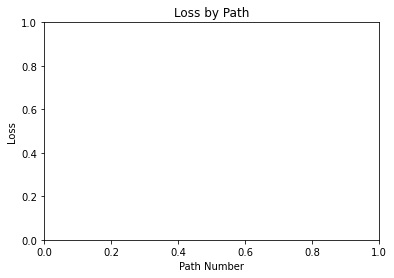

In [ ]:
import seaborn as sns 

plt.title("Loss by Path")
plt.ylabel("Loss")
plt.xlabel("Path Number")
plt.bar([i+1 for i in range(len(total_loss))] ,[np.array(x.detach().cpu()) for x in total_loss])
plt.show()

In [ ]:
X_date

array([['1997-05-19', '1997-05-20', '1997-05-21', ..., '1997-08-14',
        '1997-08-15', '1997-08-18'],
       ['1997-05-20', '1997-05-21', '1997-05-22', ..., '1997-08-15',
        '1997-08-18', '1997-08-19'],
       ['1997-05-21', '1997-05-22', '1997-05-23', ..., '1997-08-18',
        '1997-08-19', '1997-08-20'],
       ...,
       ['2021-07-05', '2021-07-06', '2021-07-07', ..., '2021-09-30',
        '2021-10-01', '2021-10-04'],
       ['2021-07-06', '2021-07-07', '2021-07-08', ..., '2021-10-01',
        '2021-10-04', '2021-10-05'],
       ['2021-07-07', '2021-07-08', '2021-07-09', ..., '2021-10-04',
        '2021-10-05', '2021-10-06']], dtype=object)

<AxesSubplot:xlabel='date'>

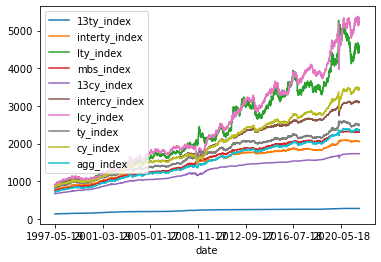

In [ ]:
df.plot()

In [ ]:
    # Epoch 
    Model.train()
    for epoch in range(epoch_num):
        print ("epoch: ", epoch)
        
        epoch_train_loss = []
        
        for data in train_loader:
            train_X, train_Y = data['X'], data['Y']
            
            print ("train_X: ", train_X)
            print ("train_Y: ", train_Y)
            train_pred = Model(train_X)
            
            loss_train = criterion(train_pred, train_Y)
            loss_train.backward()
            optimizer.step()
            optimizer.zero_grad()
            print ("Loss: ", loss_train)
            

    # pred_tr = Model(TRAIN)
    # loss_tr = criterion(pred_tr, label)
    
    # TEST 
        # TEST Dataloader generation 
    Model.eval()
    for val_ind, valid in enumerate(valid_set):
        # print ('len vald: ', len(valid_set))
        valid_ds = TensorDataset(all_X_training_data[valid], all_y_training_data[valid])
        valid_dl = DataLoader(valid_ds, batch_size = batch_num, shuffle = True)
        
        for valid_x, valid_y in valid_dl:
            
            val_pred = Model(valid_x)
            
            criterion(val_pred, valid_y)
            
            
        path_ind = train_valid_path[(train_ind, val_ind)]
        # print (train_ind, val_ind)
        # print ("path_ind: ", path_ind)    
        # total_loss[path_ind] += loss_val
        
for i in range(len(total_loss)):
    total_loss[i] /= n_test



# print ("\n")
# print ("train shape: ", train.shape, "valid shape: ", valid.shape)
# train_shape_ls.append(train.shape)
# valid_shape_ls.append(valid.shape)

IndentationError: expected an indented block (Temp/ipykernel_18876/1026472396.py, line 46)

In [ ]:
train

NameError: name 'train' is not defined

In [ ]:
X[train].shape

(5088, 66, 16, 1)

In [ ]:
train.shape


(5088,)

In [ ]:
train_ind, val_ind

(0, 0)

In [ ]:
train_valid_path[train_ind, val_ind]

0

In [ ]:
# Train - Test -Path 로 이어지는 dictionary 만들기 

path_ind = 0

train_test_path = {
    [i] for i in range(model_num)
}

train_ls = total_path_train[path_ind]
for train_ind in train_ls: 
    train_test_path[]
    


[1, 2, 3, 4, 5, 6, 7, 8, 9]

# X, Y generation 

In [ ]:

def generate_xy_seq(df: pd.DataFrame, x_seq = 66, y_seq = 22):
    """
    Generate samples from
    :param df:
    :param x_seq:
    :param y_seq:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """
    num_samples, num_nodes = df.shape
    dates_arr = np.array(df.index)
    data = np.expand_dims(df.values, axis = -1) # df -> array [N, F, 1]

    x_offsets = np.arange(-x_seq+1, 1)  
    y_offsets = np.arange(1, y_seq+1)

    # feature_list = [data]

    x, y = [], []
    x_date, y_date = [],[]

    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))

    for t in range(min_t, max_t):
        # value seperation
        x.append(data[t+x_offsets, ...])
        y.append(data[t+y_offsets, ...])
        # date seperation
        x_date.append(dates_arr[t+x_offsets])
        y_date.append(dates_arr[t+y_offsets])
        
    x = np.stack(x, axis = 0)
    y = np.stack(y, axis = 0)

    x_date = np.stack(x_date, axis = 0)
    y_date = np.stack(y_date, axis = 0)

    return x, y, x_date, y_date

In [ ]:
x, y, x_date, y_date = generate_xy_seq(df)

In [ ]:
x.shape

(6298, 66, 16, 1)

In [ ]:
x_date.shape

(6298, 66)

# CPCV
- 6C2
- purging
- embargo 

In [ ]:
def initialize(asset_prices):
    '''
    필요한 값들 생성

    :param asset_prices: (pd.DataFrame) Asset prices
    '''
    asset_name       = asset_prices.columns
    number_of_assets = asset_name.size
    time             = asset_prices.index
    length_of_time   = time.size
    first_weights    = np.ones(number_of_assets) / number_of_assets 
    all_weights      = np.zeros((length_of_time + 1, number_of_assets))

    return asset_name, number_of_assets, time, length_of_time, first_weights, all_weights


def calculate_return(asset_prices, resample_by=None):
    """
    수익률 계산 , 기간 resample 가능하게 만들기

    :param asset_prices: (pd.DataFrame) Asset prices
    :param resample_by: (str) Period to resample data, None for no resampling
    :return: (pd.DataFrame) Returns per asset
    """
    if resample_by:
        asset_prices = asset_prices.resample(resample_by).last()
    asset_returns = asset_prices.pct_change().fillna(0)
    return asset_returns

# 데이터분리 

In [ ]:
a = []
# for i in range(10):
a.append(list(range(1,10)))
a.append(list(range(45,85)))

In [ ]:
[np.array(x) for x in a]

[array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84])]

In [ ]:
from itertools import combinations

# Splitting

In [ ]:
i +=1
print ('i:', i)
train, valid = next(gen)
print ("\n")
print ("train shape: ", train.shape, "valid shape: ", valid.shape)
train_shape_ls.append(train.shape)
valid_shape_ls.append(valid.shape)

i: 2
current test_splits:  [[0, 1060], [2120, 3180]]
[0] [2]


train shape:  (4090,) valid shape:  (2120,)


In [ ]:
print ((1060-0)+(6360 - 5300))

2120


In [ ]:
train_shape_ls

[(4165,), (4090,)]

In [ ]:
valid_shape_ls

[(2120,), (2120,)]

In [ ]:
fold_dict = {}

for key, value in enumerate(fold_set):
    fold_dict[key] = value

In [ ]:
fold_dict

{0: (0, 852),
 1: (852, 1704),
 2: (1704, 2555),
 3: (2555, 3406),
 4: (3406, 4257),
 5: (4257, 5108)}

In [ ]:
test_splits

NameError: name 'test_splits' is not defined

In [ ]:
combinatorial_test_ranges = cv_gen_purged._generate_combinatorial_test_ranges(fold_dict)

In [ ]:
combinatorial_test_ranges

[[(0, 852), (852, 1704)],
 [(0, 852), (1704, 2555)],
 [(0, 852), (2555, 3406)],
 [(0, 852), (3406, 4257)],
 [(0, 852), (4257, 5108)],
 [(852, 1704), (1704, 2555)],
 [(852, 1704), (2555, 3406)],
 [(852, 1704), (3406, 4257)],
 [(852, 1704), (4257, 5108)],
 [(1704, 2555), (2555, 3406)],
 [(1704, 2555), (3406, 4257)],
 [(1704, 2555), (4257, 5108)],
 [(2555, 3406), (3406, 4257)],
 [(2555, 3406), (4257, 5108)],
 [(3406, 4257), (4257, 5108)]]

In [ ]:
len(combinatorial_test_ranges)

15

In [ ]:
sample_info_sets[0]

'1997-06-05'

In [ ]:
sample_info_sets

date
1997-05-20    1997-06-05
1997-05-21    1997-06-06
1997-05-22    1997-06-09
1997-05-23    1997-06-10
1997-05-26    1997-06-11
                 ...    
2021-09-28    2021-10-14
2021-09-29    2021-10-15
2021-09-30    2021-10-18
2021-10-01    2021-10-19
2021-10-04    2021-10-20
Name: date, Length: 6360, dtype: object